In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Implementasi Filter Kalman untuk Estimasi Posisi Robot

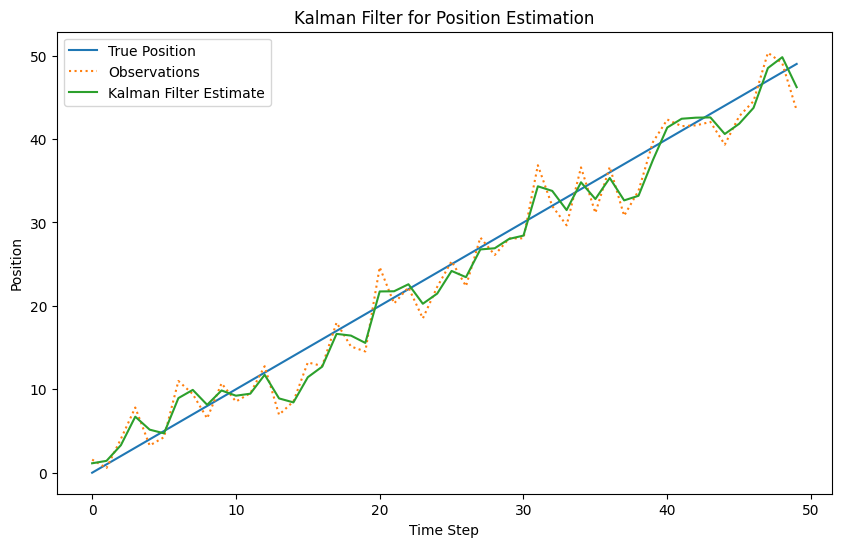

In [3]:
# Parameter simulasi
dt = 1.0  # Selang waktu
A = np.array([[1, dt], [0, 1]])  # Matriks transisi
H = np.array([[1, 0]])  # Matriks observasi
Q = np.array([[1, 0], [0, 3]])  # Noise proses
R = np.array([[10]])  # Noise observasi

# Keadaan awal
x = np.array([[0], [1]])  # Posisi awal (posisi, kecepatan)
P = np.eye(2)  # Kovariansi kesalahan awal

# Data observasi (dengan noise)
np.random.seed(42)
true_positions = [0 + i for i in range(50)]
observations = [pos + np.random.normal(0, np.sqrt(R[0, 0])) for pos in true_positions]

# Simulasi Filter Kalman
estimated_positions = []
for z in observations:
    # Prediksi
    x = A @ x
    P = A @ P @ A.T + Q

    # Update
    z = np.array([[z]])  # Observasi
    y = z - H @ x  # Error inovasi
    S = H @ P @ H.T + R  # Kovariansi inovasi
    K = P @ H.T @ np.linalg.inv(S)  # Gain Kalman
    x = x + K @ y
    P = (np.eye(2) - K @ H) @ P

    estimated_positions.append(x[0, 0])

# Plot hasil
plt.figure(figsize=(10, 6))
plt.plot(true_positions, label="True Position")
plt.plot(observations, label="Observations", linestyle="dotted")
plt.plot(estimated_positions, label="Kalman Filter Estimate")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.title("Kalman Filter for Position Estimation")
plt.show()


## 2. Implementasi Filter Partikel untuk Estimasi Posisi Robot

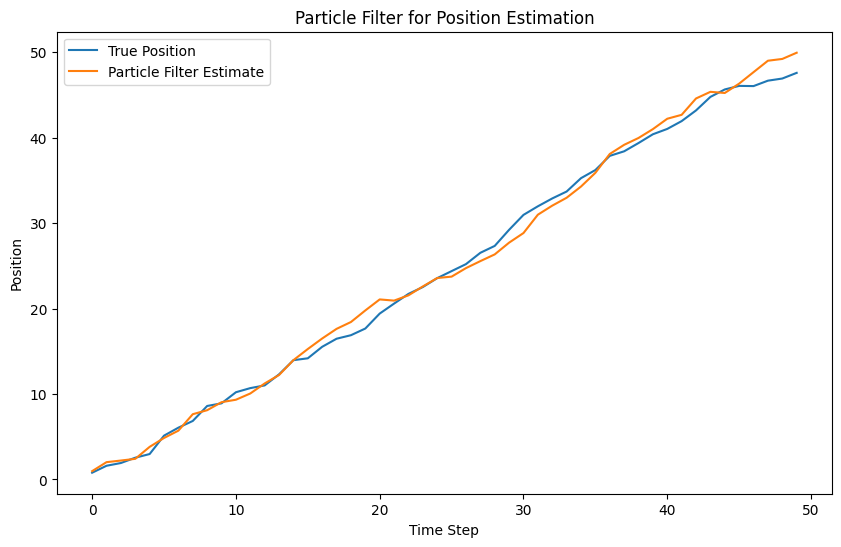

In [4]:
# Parameter simulasi
n_particles = 1000  # Jumlah partikel
true_position = 0  # Posisi awal sebenarnya
particles = np.random.uniform(-20, 20, size=n_particles)  # Partikel awal
weights = np.ones(n_particles) / n_particles  # Bobot awal

# Fungsi model gerak dan observasi
def motion_model(particles, velocity, noise=0.5):
    return particles + velocity + np.random.normal(0, noise, size=particles.shape)

def measurement_model(particles, measurement, noise=2.0):
    return np.exp(-((particles - measurement) ** 2) / (2 * noise ** 2))

# Simulasi
true_positions = []
particle_estimates = []

for t in range(50):
    # Gerak robot
    velocity = 1  # Kecepatan
    true_position += velocity + np.random.normal(0, 0.5)
    true_positions.append(true_position)

    # Perbarui partikel
    particles = motion_model(particles, velocity)

    # Pengukuran
    measurement = true_position + np.random.normal(0, 2.0)
    weights = measurement_model(particles, measurement)
    weights /= np.sum(weights)  # Normalisasi bobot

    # Estimasi
    estimate = np.sum(particles * weights)
    particle_estimates.append(estimate)

    # Resampling
    indices = np.random.choice(range(n_particles), size=n_particles, p=weights)
    particles = particles[indices]
    weights = np.ones(n_particles) / n_particles

# Plot hasil
plt.figure(figsize=(10, 6))
plt.plot(true_positions, label="True Position")
plt.plot(particle_estimates, label="Particle Filter Estimate")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.title("Particle Filter for Position Estimation")
plt.show()

## 3. Implementasi Localization dengan Sensor IMU dan Lidar

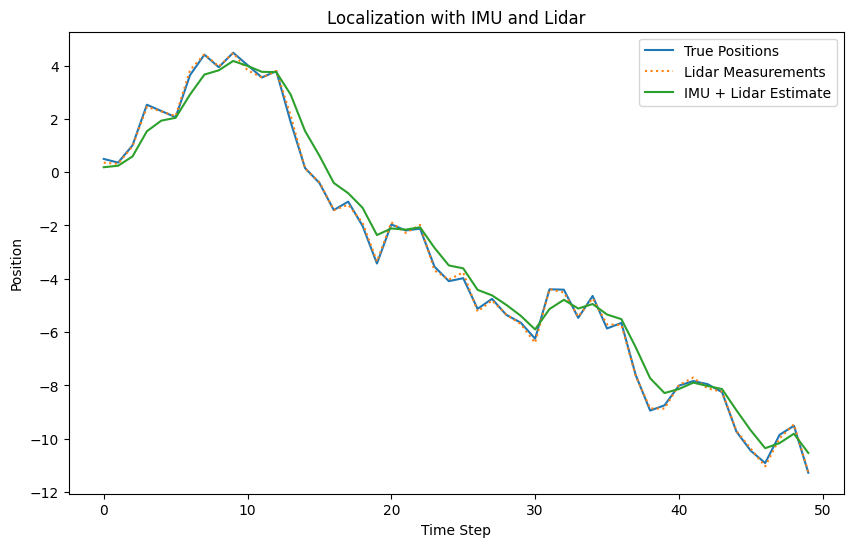

In [5]:
# Parameter simulasi
dt = 0.1  # Selang waktu
timesteps = 50

# Data simulasi
np.random.seed(42)
true_positions = np.cumsum(np.random.normal(0, 1, timesteps))  # Posisi sebenarnya
imu_readings = np.random.normal(0, 0.05, timesteps)  # Simulasi noise IMU
lidar_readings = true_positions + np.random.normal(0, 0.1, timesteps)  # Simulasi noise Lidar

# Estimasi posisi menggunakan kombinasi IMU dan Lidar
estimated_positions = []
position = 0  # Posisi awal
for t in range(timesteps):
    # Prediksi posisi menggunakan IMU
    position += imu_readings[t]
    # Perbaikan menggunakan Lidar
    position = 0.5 * position + 0.5 * lidar_readings[t]
    estimated_positions.append(position)

# Plot hasil
plt.figure(figsize=(10, 6))
plt.plot(true_positions, label="True Positions")
plt.plot(lidar_readings, label="Lidar Measurements", linestyle="dotted")
plt.plot(estimated_positions, label="IMU + Lidar Estimate")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.title("Localization with IMU and Lidar")
plt.show()

## 4. Implementasi Simulasi Ekstensi Kalman Filter untuk Navigasi

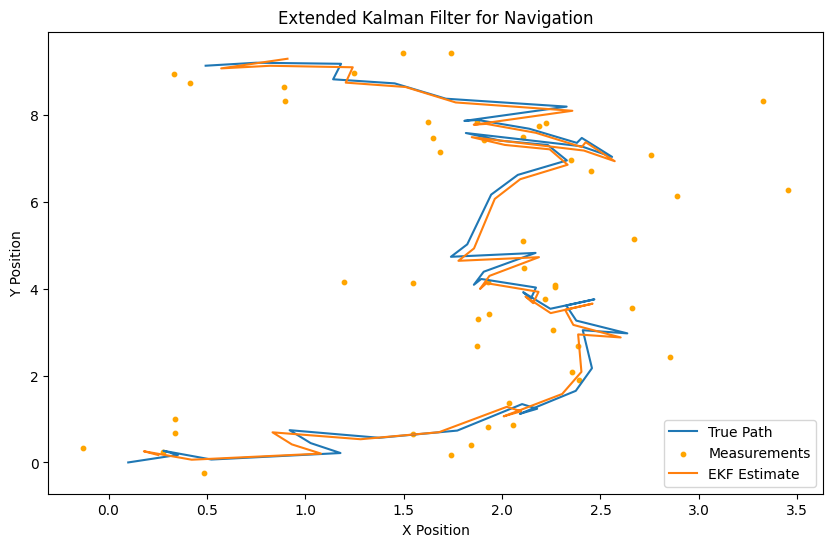

In [6]:
# Fungsi model gerak
def motion_model(state, control, dt):
    x, y, theta = state
    v, omega = control
    x += v * np.cos(theta) * dt
    y += v * np.sin(theta) * dt
    theta += omega * dt
    return np.array([x, y, theta])

# Fungsi Jacobian dari model gerak
def jacobian_motion_model(state, control, dt):
    x, y, theta = state
    v, omega = control
    J = np.array([
        [1, 0, -v * np.sin(theta) * dt],
        [0, 1, v * np.cos(theta) * dt],
        [0, 0, 1]
    ])
    return J

# Parameter simulasi
dt = 0.1
timesteps = 50
R = np.diag([0.1, 0.1, np.deg2rad(1)])  # Noise proses
Q = np.diag([0.5, 0.5])  # Noise observasi

# Keadaan awal
state = np.array([0, 0, 0])  # (x, y, theta)
P = np.eye(3)

# Simulasi
true_states = []
observations = []
estimated_states = []

for t in range(timesteps):
    # Simulasi keadaan sebenarnya
    control = np.array([1, np.deg2rad(10)])  # (v, omega)
    state = motion_model(state, control, dt)
    true_states.append(state)

    # Simulasi pengukuran dengan noise
    z = state[:2] + np.random.multivariate_normal([0, 0], Q)
    observations.append(z)

    # EKF Prediksi
    state_pred = motion_model(state, control, dt)
    F = jacobian_motion_model(state, control, dt)
    P_pred = F @ P @ F.T + R

    # EKF Update
    H = np.array([[1, 0, 0], [0, 1, 0]])
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + Q)
    state = state_pred + K @ (z - H @ state_pred)
    P = (np.eye(3) - K @ H) @ P_pred
    estimated_states.append(state)

# Plot hasil
true_states = np.array(true_states)
observations = np.array(observations)
estimated_states = np.array(estimated_states)

plt.figure(figsize=(10, 6))
plt.plot(true_states[:, 0], true_states[:, 1], label="True Path")
plt.scatter(observations[:, 0], observations[:, 1], label="Measurements", color="orange", s=10)
plt.plot(estimated_states[:, 0], estimated_states[:, 1], label="EKF Estimate")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Extended Kalman Filter for Navigation")
plt.show()

## 5. Implementasi Particle Filter untuk Navigasi

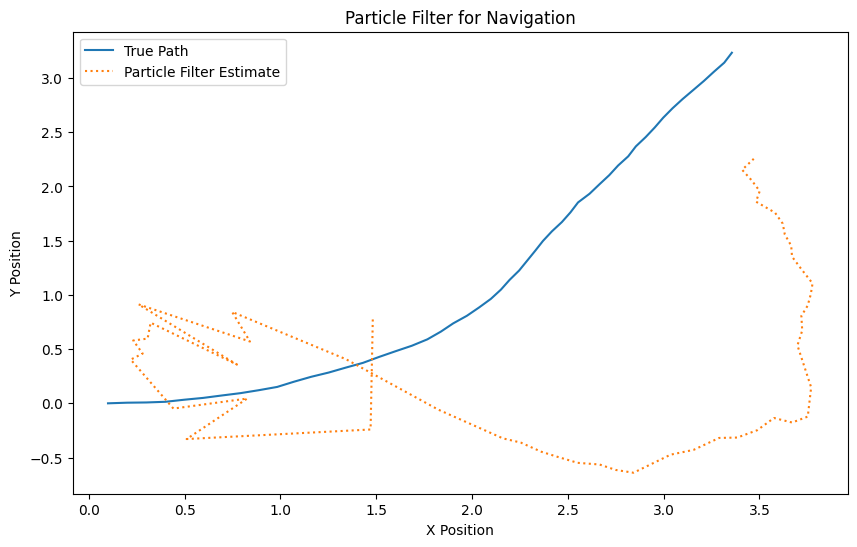

In [8]:
# Parameter simulasi
n_particles = 500
particles = np.random.uniform(-10, 10, size=(n_particles, 3)).astype(np.float64)  # Pastikan tipe data float64
weights = np.ones(n_particles) / n_particles

# Fungsi model gerak
def motion_model(particles, control, dt):
    v, omega = control
    particles[:, 0] += v * np.cos(particles[:, 2]) * dt
    particles[:, 1] += v * np.sin(particles[:, 2]) * dt
    particles[:, 2] += omega * dt + np.random.normal(0, np.deg2rad(5), size=particles[:, 2].shape)
    return particles

# Fungsi pengukuran dan resampling
def measurement_model(particles, measurement, noise=1.0):
    distances = np.linalg.norm(particles[:, :2] - measurement, axis=1)
    return np.exp(-distances**2 / (2 * noise**2))

# Simulasi
true_state = np.array([0, 0, 0], dtype=np.float64)  # Tipe data float64 untuk konsistensi
true_states = []
particle_estimates = []

for t in range(timesteps):
    # Gerak sebenarnya
    control = np.array([1, np.deg2rad(10)])  # (v, omega)
    true_state = motion_model(np.array([true_state]), control, dt)[0]
    true_states.append(true_state)

    # Pengukuran
    measurement = true_state[:2] + np.random.normal(0, 1, 2)

    # Update partikel
    particles = motion_model(particles, control, dt)
    weights = measurement_model(particles, measurement)
    weights /= np.sum(weights)

    # Estimasi
    estimate = np.average(particles, weights=weights, axis=0)
    particle_estimates.append(estimate)

    # Resampling
    indices = np.random.choice(range(n_particles), size=n_particles, p=weights)
    particles = particles[indices]
    weights = np.ones(n_particles) / n_particles

# Plot hasil
true_states = np.array(true_states)
particle_estimates = np.array(particle_estimates)

plt.figure(figsize=(10, 6))
plt.plot(true_states[:, 0], true_states[:, 1], label="True Path")
plt.plot(particle_estimates[:, 0], particle_estimates[:, 1], label="Particle Filter Estimate", linestyle="dotted")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Particle Filter for Navigation")
plt.show()